In [1]:
from models.cnep import CNEP

from data.data_generators import *
import torch


torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
batch_size = 64
n_max, m_max = 8, 8  # max number of points in context set and target set

t_steps = 200
num_demos = 256
num_classes = 4
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 64
num_val_indiv = num_val//num_classes

In [3]:
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

for i in range(num_classes):
    start_ind = i * num_indiv
    coeff = (i+1) / 3 * torch.pi
    phase_shifts = torch.rand(num_indiv) * 3e-2 * torch.pi

    # Expand dimensions for proper broadcasting (without the extra unsqueeze)
    expanded_x = x.expand(num_indiv, -1)  # Shape: (32, 200)
    expanded_x += 0.1
    expanded_phase_shifts = phase_shifts.unsqueeze(1).expand(-1, x.shape[1])  # Shape: (32, 200)

    # Now the element-wise operations work correctly
    y[start_ind: start_ind + num_indiv, :, :] = torch.unsqueeze(generate_sin(expanded_x * coeff + expanded_phase_shifts), 2)

    noise = torch.unsqueeze(torch.clamp(torch.randn(vx.shape)*0.01, min=0) - noise_clip, -1)

    start_val_ind = i*num_val_indiv
    start_ind = i*num_indiv
    vy[start_val_ind:start_val_ind+num_val_indiv] = y[start_ind:start_ind+num_val_indiv].clone() + noise

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

X: torch.Size([256, 200, 1]) Y: torch.Size([256, 200, 1]) VX: torch.Size([64, 200, 1]) VY: torch.Size([64, 200, 1])


Text(0.5, 1.0, 'Sine Waves')

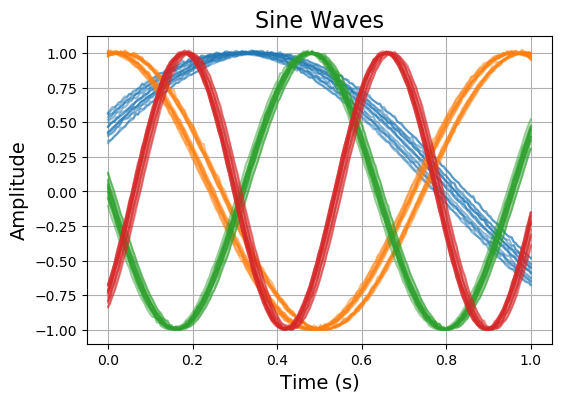

In [4]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
# sns.set_palette('tab10')

# plt.figure(figsize=(6, 4))
# for i in range(num_val):
#     plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), color=colors[i//num_val_indiv], alpha=0.5)
#     # plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), 'k', alpha=0.5)

# # plt.legend(loc='lower left', fontsize=14)
# plt.grid(True)
# plt.xlabel('Time (s)', fontsize=14)
# plt.ylabel('Amplitude', fontsize=14)
# plt.title(f'Sine Waves', fontsize=16)

In [5]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)
        obs[i, :n, dx:] = traj[n_ids]
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = (m_ids/t_steps).unsqueeze(1)
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)
        val_obs[i, :n, dx:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = (m_ids/t_steps).unsqueeze(1)
        val_tar_y[i] = traj[m_ids]

In [6]:
model2_ = CNEP(1, 1, n_max, n_max, [256, 256], num_decoders=2, decoder_hidden_dims=[256, 256], batch_size=batch_size, scale_coefs=True, device=device)
optimizer2 = torch.optim.Adam(lr=3e-4, params=model2_.parameters())

model4_ = CNEP(1, 1, n_max, n_max, [256, 256], num_decoders=4, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer4 = torch.optim.Adam(lr=3e-4, params=model4_.parameters())

model8_ = CNEP(1, 1, n_max, n_max, [256, 256], num_decoders=8, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
optimizer8 = torch.optim.Adam(lr=3e-4, params=model8_.parameters())

def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("cnep2:", get_parameter_count(model2_))
print("cnep4:", get_parameter_count(model4_))
print("cnep8:", get_parameter_count(model8_))

if torch.__version__ >= "2.0":
    model2, model4, model8 = torch.compile(model2_), torch.compile(model4_), torch.compile(model8_)
else:
    model2, model4, model8 = model2_, model4_, model8_

cnep2: 200198
cnep4: 200716
cnep8: 201752


In [7]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/ablation/sines_4/2_4_8/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 2_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss2, avg_loss4, avg_loss8 = 0, 0, 0

val_per_epoch = 5000
min_vl2, min_vl4, min_vl8 = 1000000, 1000000, 1000000

mse_loss = torch.nn.MSELoss()

tl2, tl4, tl8 = [], [], []
ve2, ve4, ve8 = [], [], []

cnep_tl_path = f'{root_folder}cnep_training_loss.pt'
cnep_ve_path = f'{root_folder}cnep_validation_error.pt'

for epoch in range(epochs):
    epoch_loss2, epoch_loss4, epoch_loss8 = 0, 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        prepare_masked_batch(y, traj_ids[i])

        optimizer2.zero_grad()
        pred2, gate2 = model2(obs, tar_x, obs_mask)
        loss2, nll2 = model2.loss(pred2, gate2, tar_y, tar_mask)
        loss2.backward()
        optimizer2.step()


        optimizer4.zero_grad()
        pred4, gate4 = model4(obs, tar_x, obs_mask)
        loss4, nll4 = model4.loss(pred4, gate4, tar_y, tar_mask)
        loss4.backward()
        optimizer4.step()


        optimizer8.zero_grad()
        pred8, gate8 = model8(obs, tar_x, obs_mask)
        loss8, nll8 = model8.loss(pred8, gate8, tar_y, tar_mask)
        loss8.backward()
        optimizer8.step()

        epoch_loss2 += nll2.item()
        epoch_loss4 += nll4.item()
        epoch_loss8 += nll8.item()

    epoch_loss2 = epoch_loss2/epoch_iter
    epoch_loss4 = epoch_loss4/epoch_iter
    epoch_loss8 = epoch_loss8/epoch_iter

    tl2.append(epoch_loss2)
    tl4.append(epoch_loss4)
    tl8.append(epoch_loss8)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss2, val_loss4, val_loss8 = 0, 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(vy, v_traj_ids[j])

                p_wta, g_wta = model2.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss2 += mse_loss(vp_means, val_tar_y).item()

                p_wta, g_wta = model4.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss4 += mse_loss(vp_means, val_tar_y).item()

                p_wta, g_wta = model8.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss8 += mse_loss(vp_means, val_tar_y).item()

            ve2.append(val_loss2)
            ve4.append(val_loss4)
            ve8.append(val_loss8)

            if val_loss2 < min_vl2:
                min_vl2 = val_loss2
                print(f'New best 2: {min_vl2}')
                torch.save(model2_.state_dict(), f'{root_folder}saved_models/cnep2.pt')

            if val_loss4 < min_vl4:
                min_vl4 = val_loss4
                print(f'New best 4: {min_vl4}')
                torch.save(model4_.state_dict(), f'{root_folder}saved_models/cnep4.pt')

            if val_loss8 < min_vl8:
                min_vl8 = val_loss8
                print(f'New best 8: {min_vl8}')
                torch.save(model8_.state_dict(), f'{root_folder}saved_models/cnep8.pt')
            
            print(f'Bests: {min_vl2}, {min_vl4}, {min_vl8}')

    avg_loss2 += epoch_loss2
    avg_loss4 += epoch_loss4
    avg_loss8 += epoch_loss8

    if epoch % val_per_epoch == 0:
        print("Epoch: {}, CNEP Losses: {}, {}, {}".format(epoch, avg_loss2/val_per_epoch, avg_loss4/val_per_epoch, avg_loss8/val_per_epoch))
        avg_loss2, avg_loss4, avg_loss8 = 0, 0, 0

torch.save(torch.Tensor(tl2), cnep_tl_path+'_2')
torch.save(torch.Tensor(ve2), cnep_ve_path+'_2')
torch.save(torch.Tensor(tl4), cnep_tl_path+'_4')
torch.save(torch.Tensor(ve4), cnep_ve_path+'_4')
torch.save(torch.Tensor(tl8), cnep_tl_path+'_8')
torch.save(torch.Tensor(ve8), cnep_ve_path+'_8')

New best 2: 0.46934348344802856
New best 4: 0.47086387872695923
New best 8: 0.47610509395599365
Bests: 0.46934348344802856, 0.47086387872695923, 0.47610509395599365
Epoch: 0, CNEP Losses: 0.00010676324069499969, 5.3721478581428525e-05, 2.6855048537254334e-05
New best 2: 0.24017757177352905
New best 4: 0.343999981880188
New best 8: 0.2855378985404968
Bests: 0.24017757177352905, 0.343999981880188, 0.2855378985404968
Epoch: 5000, CNEP Losses: 0.24966845246034208, 0.15293474862379952, 0.07019276853480842
New best 2: 0.19962386786937714
New best 4: 0.2075849175453186
New best 8: 0.20535540580749512
Bests: 0.19962386786937714, 0.2075849175453186, 0.20535540580749512
Epoch: 10000, CNEP Losses: -0.039570387465786186, -0.004950492238998413, 0.01097987797759415
New best 4: 0.16380815207958221
New best 8: 0.17192786931991577
Bests: 0.19962386786937714, 0.16380815207958221, 0.17192786931991577
Epoch: 15000, CNEP Losses: -0.18548170231133698, -0.07043257202081149, -0.0132629110794398
New best 2: 0.

KeyboardInterrupt: 